# Exercise sheet

Some general remarks about the exercises:
* For your convenience functions from the lecture are included below. Feel free to reuse them without copying to the exercise solution box.
* For each part of the exercise a solution box has been added, but you may insert additional boxes. Do not hesitate to add Markdown boxes for textual or LaTeX answers (via `Cell > Cell Type > Markdown`). But make sure to replace any part that says `YOUR CODE HERE` or `YOUR ANSWER HERE` and remove the `raise NotImplementedError()`.
* Please make your code readable by humans (and not just by the Python interpreter): choose informative function and variable names and use consistent formatting. Feel free to check the [PEP 8 Style Guide for Python](https://www.python.org/dev/peps/pep-0008/) for the widely adopted coding conventions or [this guide for explanation](https://realpython.com/python-pep8/).
* Make sure that the full notebook runs without errors before submitting your work. This you can do by selecting `Kernel > Restart & Run All` in the jupyter menu.
* For some exercises test cases have been provided in a separate cell in the form of `assert` statements. When run, a successful test will give no output, whereas a failed test will display an error message.
* Each sheet has 100 points worth of exercises. Note that only the grades of sheets number 2, 4, 6, 8 count towards the course examination. Submitting sheets 1, 3, 5, 7 & 9 is voluntary and their grades are just for feedback.

Please fill in your name here:

In [1]:
NAME = "Kees van Kempen"
NAMES_OF_COLLABORATORS = ""

---

**Exercise sheet 8**

Code from the lectures:

In [2]:
import numpy as np
rng = np.random.default_rng()  
import matplotlib.pylab as plt
%matplotlib inline

def fan_triangulation(n):
    '''Generates a fan-shaped triangulation of even size n.'''
    return np.array([[(i-3)%(3*n),i+5,i+4,(i+6)%(3*n),i+2,i+1] 
                     for i in range(0,3*n,6)],dtype=np.int32).flatten()

def is_fpf_involution(adj):
    '''Test whether adj defines a fixed-point free involution.'''
    for x, a in enumerate(adj):
        if a < 0 or a >= len(adj) or x == a or adj[a] != x:
            return False
    return True

from collections import deque 

def triangle_neighbours(adj,i):
    '''Return the indices of the three neighboring triangles.'''
    return [j//3 for j in adj[3*i:3*i+3]]

def connected_components(adj):
    '''Calculate the number of connected components of the triangulation.'''
    n = len(adj)//3   # the number of triangles
    # array storing the component index of each triangle
    component = np.full(n,-1,dtype=np.int32)   
    index = 0
    for i in range(n):
        if component[i] == -1:    # new component found, let us explore it
            component[i] = index
            queue = deque([i])   # use an exploration queue for breadth-first search
            while queue:
                for nbr in triangle_neighbours(adj,queue.pop()):
                    # the neighboring triangle has not been explored yet
                    if component[nbr] == -1:  
                        component[nbr] = index
                        queue.appendleft(nbr)   # add it to the exploration queue
            index += 1
    return index

def next_around_triangle(i):
    '''Return the label of the side following side i in counter-clockwise direction.'''
    return i - i%3 + (i+1)%3

def prev_around_triangle(i):
    '''Return the label of the side preceding side i in counter-clockwise direction.'''
    return i - i%3 + (i-1)%3

def vertex_list(adj):
    '''
    Return the number of vertices and an array `vertex` of the same size 
    as `adj`, such that `vertex[i]` is the index of the vertex at the 
    start (in ccw order) of the side labeled `i`.
    '''
    # a side i that have not been visited yet has vertex[i]==-1
    vertex = np.full(len(adj),-1,dtype=np.int32)  
    vert_index = 0 
    for i in range(len(adj)):
        if vertex[i] == -1:
            side = i
            while vertex[side] == -1:  # find all sides that share the same vertex
                vertex[side] = vert_index
                side = next_around_triangle(adj[side])
            vert_index += 1
    return vert_index, vertex

def number_of_vertices(adj):
    '''Calculate the number of vertices in the triangulation.'''
    return vertex_list(adj)[0]

def is_sphere_triangulation(adj):
    '''Test whether adj defines a triangulation of the 2-sphere.'''
    if not is_fpf_involution(adj) or connected_components(adj) != 1:
        return False
    num_vert = number_of_vertices(adj)
    num_face = len(adj)//3
    num_edge = len(adj)//2
    # verify Euler's formula for the sphere
    return num_vert - num_edge + num_face == 2

def flip_edge(adj,i):
    if adj[i] == next_around_triangle(i) or adj[i] == prev_around_triangle(i):
        # flipping an edge that is adjacent to the same triangle on both sides makes no sense
        return False
    j = prev_around_triangle(i)
    k = adj[i]
    l = prev_around_triangle(k)
    n = adj[l]
    adj[i] = n  # it is important that we first update
    adj[n] = i  # these adjacencies, before determining m,
    m = adj[j]  # to treat the case j == n appropriately
    adj[k] = m
    adj[m] = k
    adj[j] = l
    adj[l] = j
    return True

def random_flip(adj):
    random_side = rng.integers(0,len(adj))
    return flip_edge(adj,random_side)

import networkx as nx
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

def triangulation_edges(triangulation,vertex):
    '''Return a list of vertex-id pairs corresponding to the edges in the triangulation.'''
    return [(vertex[i],vertex[j]) for i,j in enumerate(triangulation) if i < j]

def triangulation_triangles(triangulation,vertex):
    '''Return a list of vertex-id triples corresponding to the triangles in the triangulation.'''
    return [vertex[i:i+3] for i in range(0,len(triangulation),3)]

def plot_triangulation_3d(adj):
    '''Display an attempt at embedding the triangulation in 3d.'''
    num_vert, vertex = vertex_list(adj)
    edges = triangulation_edges(adj,vertex)
    triangles = triangulation_triangles(adj,vertex)
    # use the networkX 3d graph layout algorithm to find positions for the vertices
    pos = np.array(list(nx.spring_layout(nx.Graph(edges),dim=3).values()))
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    tris = Poly3DCollection(pos[triangles])
    tris.set_edgecolor('k')
    ax.add_collection3d(tris)
    ax.set_xlim3d(np.amin(pos[:,0]),np.amax(pos[:,0]))
    ax.set_ylim3d(np.amin(pos[:,1]),np.amax(pos[:,1]))
    ax.set_zlim3d(np.amin(pos[:,2]),np.amax(pos[:,2]))
    plt.show()
    
def vertex_neighbors_list(adj):
    '''Return a list `neighbors` such that `neighbors[v]` is a list of neighbors of the vertex v.'''
    num_vertices, vertex = vertex_list(adj)
    neighbors = [[] for _ in range(num_vertices)]
    for i,j in enumerate(adj):
        neighbors[vertex[i]].append(vertex[j])
    return neighbors

def vertex_distance_profile(adj,max_distance=30):
    '''Return array `profile` of size `max_distance` such that `profile[r]` is the number
    of vertices that have distance r to a randomly chosen initial vertex.'''
    profile = np.zeros((max_distance),dtype=np.int32)
    neighbors = vertex_neighbors_list(adj)
    num_vertices = len(neighbors)
    start = rng.integers(num_vertices) # random starting vertex
    distance = np.full(num_vertices,-1,dtype=np.int32)  # array tracking the known distances (-1 is unknown)
    queue = deque([start])   # use an exploration queue for the breadth-first search
    distance[start] = 0
    profile[0] = 1  # of course there is exactly 1 vertex at distance 0
    while queue:
        current = queue.pop()
        d = distance[current] + 1  # every unexplored neighbour will have this distance
        if d >= max_distance:
            break
        for nbr in neighbors[current]:
            if distance[nbr] == -1:  # this neighboring vertex has not been explored yet
                distance[nbr] = d
                profile[d] += 1
                queue.appendleft(nbr)   # add it to the exploration queue
    return profile
    
def perform_sweeps(adj,t):
    '''Perform t sweeps of flip moves, where 1 sweep is N moves.'''
    for _ in range(len(adj)*t//3):
        random_flip(adj)

def batch_estimate(data,observable,k):
    '''Devide data into k batches and apply the function observable to each.
    Returns the mean and standard error.'''
    batches = np.reshape(data,(k,-1))
    values = np.apply_along_axis(observable, 1, batches)
    return np.mean(values), np.std(values)/np.sqrt(k-1)

## Estimating Hausdorff dimensions in various 2D quantum gravity models 

**(100 Points)**

In the lecture we considered the model of two-dimensional Dynamical Triangulations of the 2-sphere. The corresponding partition function is
$$ Z^{U}_{S^2,N} = \sum_T 1, \tag{1}$$
where the sum is over all triangulations of size $N$ with the topology of $S^2$, each of which is represented as an adjacency list $\operatorname{adj}: \{0,\ldots,3N-1\} \to \{0,\ldots,3N-1\}$. To emphasize that we are dealing with the **uniform** probability distribution on such triangulations, we have added the label $^U$. It is a lattice model of two-dimensional Euclidean quantum gravity with no coupled matter.

One can also consider two-dimensional quantum gravity coupled to matter fields (e.g. a scalar field) supported on the geometry. Formally the corresponding path integral in the continuum reads
$$ Z = \int [\mathcal{D}g_{ab}]\int [\mathcal{D}\phi] e^{-\frac{1}{\hbar}(S_E[g_{ab}] + S_m[\phi,g_{ab}])} = \int [\mathcal{D}g_{ab}]e^{-\frac{1}{\hbar}S_E[g_{ab}]} Z^*_m[g_{ab}],$$
where $S_m[\phi,g_{ab}]$ and $Z_m[g_{ab}]$ are the matter action and path integral of the field $\phi$ on the geometry described by $g_{ab}$. The natural analogue in Dynamical Triangulations is
$$Z^*_{S^2,N} = \sum_T Z^*_m[T],$$
where the sum is over the same triangulations as in (1) but now the summand $Z^*_m[T]$ is the lattice partition function of a matter system supported on the triangulation $T$, which generically depends in a non-trivial way on $T$. For instance, the matter system could be an Ising model in which the spin are supported on the triangles of $T$ and $Z^{\text{Ising}}_m[T]$ would be the corresponding Ising partition function.
In other words, when Dynamical Triangulations are coupled to matter the uniform distribution $\pi^U(T) = 1/Z^U_{S^2,N}$ is changed into a non-uniform distribution $\pi^*(T) = Z^*_m[T] / Z^*_{S^2,N}$. This can have significant effect on the critical exponents of the random triangulation as $N\to\infty$, like the Hausdorff dimension. 

The goal of this exercise is to estimate the **Hausdorff dimension** of random triangulations in four different models and to conclude based on this that they belong to four different universality classes (i.e. that if they possess well-defined continuum limits that they are described by four different EQFTs): 
* $Z^{U}_{S^2,N}$: the standard Dynamical Triangulations with **U**niform distribution (U)
* $Z^{W}_{S^2,N}$: triangulations coupled to a matter system called a Schnyder **W**ood (W)
* $Z^{S}_{S^2,N}$: triangulations coupled to a matter system called a **S**panning tree (S)
* $Z^{B}_{S^2,N}$: triangulations coupled to a matter system called a **B**ipolar orientation (B)

What these matter systems precisely represent will not be important. We have provided for you a **black box generator** that samples from the corresponding four distributions $\pi^U(T)$, $\pi^W(T)$, $\pi^S(T)$, $\pi^B(T)$. It does so in an efficient manner (linear time in $N$) using direct Monte Carlo sampling algorithms and therefore returns independent samples with exactly the desired distribution $\pi^*(T)$ (within numerical precision).

The black box generator is provided by the executable program `generator` provided to you on the science server. It can be called directly from this notebook with the following function `generate_random_triangulation`, that takes the desired size $N$ and model (`'U'`,`'W'`, `'S'`, `'B'`) and returns a single random triangulation in the usual form of an adjacency list.

In [3]:
import subprocess

def generate_random_triangulation(n,model):
    '''
    Returns a random triangulation generated by the program `generator` in the form 
    of an array of length 3n storing the adjacency information of the triangle sides.
    Parameters:
      n - number of triangles in the triangulation, must be positive and even
      model - a one-letter string specifying the model from which the triangulation is sampled:
         'U': Uniform triangulations
         'W': Schnyder-Wood-decorated triangulations
         'S': Spanning-tree decorated triangulations
         'B': Bipolar-oriented triangulations
    '''
    program = "/vol/cursus/NM042B/bin/generator"
    output = subprocess.check_output([program,"-s{}".format(n),"-t{}".format(model)]).decode('ascii').split('\n')[:-1]
    return np.array([int(num) for num in output],dtype=np.int32)

adj = generate_random_triangulation(100,'B')
is_sphere_triangulation(adj)

True

Recall that the **distance profile** $\rho_T(r)$ of a triangulation is defined as 
$$ \rho_T(r) = \frac{1}{V} \sum_{x=0}^{V-1} \sum_{y=0}^{V-1} \mathbf{1}_{\{d_T(x,y)=r\}},$$
where $V = (N+4)/2$ is the number of vertices and $d_T(x,y)$ is the graph distance between the vertices with label $x$ and $y$.

**(a)** Let $T$ be a random triangulation of size $N$ and $X$, $Y$ two independent numbers chosen uniformly from $0,\ldots,V-1$, corresponding to two random vertices in $T$. Explain with a calculation that $\frac{1}{V}\mathbb{E}[ \rho_T(r) ] = \mathbb{P}(d_T(X,Y) = r)$ and that the expected distance between $X$ and $Y$ is related to the distance profile via

$$
\mathbb{E}[d_T(X,Y)] = \frac{1}{V}\sum_{r=0}^\infty r\, \mathbb{E}[ \rho_T(r) ]. \tag{2}
$$

**(20 pts)**

YOUR ANSWER HERE

**(b)** We will work under the assumption that 

$$
\mathbb{E}[\rho_T(r)] \approx V^{1-1/d_H} f(r V^{-1/d_H})
$$ 

for a positive real number $d_H$ called the **Hausdorff dimension** and a continuous function $f$ that are both independent of $N$ but do depend on the model. Show that 

$$
\mathbb{E}[d_T(X,Y)] \approx c\,V^{1/d_H}, \qquad c = \int_0^\infty \mathrm{d}x\,x\,f(x). \tag{3}
$$

_Hint:_ Approximate the summation by an integral. **(15 pts)**

YOUR ANSWER HERE

**(c)** For each of the four models estimate $\mathbb{E}[d_T(X,Y)]$ with errors for $N = 2^7, 2^8, \ldots, 2^{12}$ using (2) and based on $100$ samples each. Store your data in the file `qgdimension.hdf5`. Make an estimate of $d_H$ (with errors) for each of the models by fitting the parameters $c$ and $d_H$ of the ansatz (3). For each model, plot the data together with the fit in a log-log plot. **(40 pts)**

In [4]:
models = ['U','W','S','B']
sizes = [2**k for k in range(7,13)]
num_vertices = (np.array(sizes)+4)/2
measurements = 100

# data gathering and storing in qgdimension.hdf5
import h5py

max_distance = 30

with h5py.File("qgdimension.hdf5", "a") as f:
    if not "num-vertices" in f:
        f.create_dataset("num-vertices",data=num_vertices)
    
    for model in models:
        models_key = f"expectation-graph-distance-{model}"
        if not models_key in f:
            graph_distance_expectations = np.zeros((len(num_vertices), measurements))
            for idx_N, N in enumerate(num_vertices):
                V = (N + 4)/2
                for idx_measurement in range(measurements):
                    adj = generate_random_triangulation(N, model)
                    expectation = 1/V * vertex_distance_profile(adj,max_distance)@np.arange(max_distance)
                    graph_distance_expectations[idx_N][idx_measurement] = expectation

            f.create_dataset(models_key,data=graph_distance_expectations)

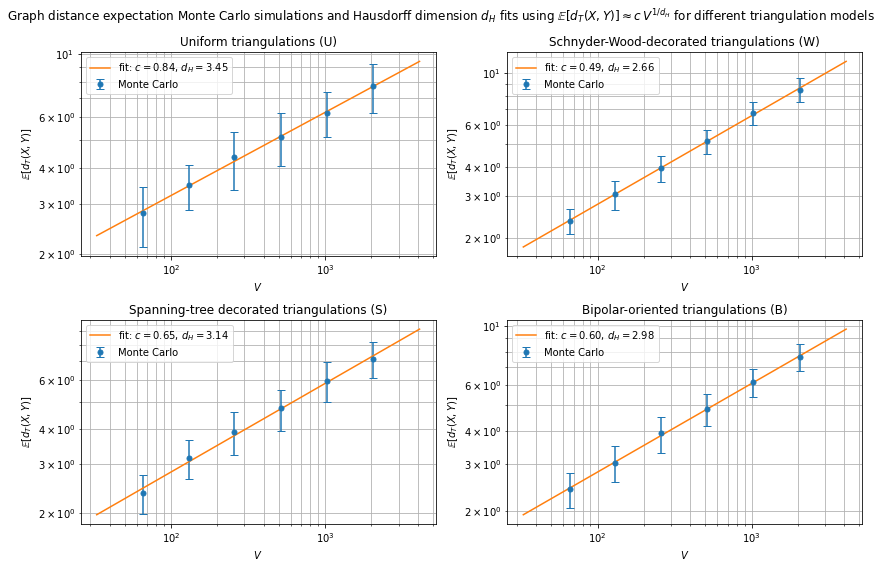

In [5]:
# Fitting and plotting
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit

# Define a dictionary of model names for the plot titles.
model_names = {"U": "Uniform triangulations",
               "W": "Schnyder-Wood-decorated triangulations",
               "S": "Spanning-tree decorated triangulations",
               "B": "Bipolar-oriented triangulations"}

d_H_list = {}

with h5py.File("qgdimension.hdf5", "r") as f:
    num_vertices = np.array(f["num-vertices"])
    expectations = {model: np.array(f[f"expectation-graph-distance-{model}"]) for model in models}
    
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))
    axs = axs.ravel()
    fig.suptitle(r"Graph distance expectation Monte Carlo simulations and Hausdorff dimension $d_H$ fits using $\mathbb{E}[d_T(X,Y)] \approx c\,V^{1/d_H}$ for different triangulation models")
    
    for idx_model, model in enumerate(models):
        # Calculate mean and standard deviation of the expectations.
        mu = np.mean(expectations[model], 1)
        sigma = np.std(expectations[model], 1)

        fitfunc = lambda V, c, d_H: c*V**(1/d_H)
        popt, pcov = curve_fit(fitfunc, num_vertices, mu, sigma=sigma)
        d_H_list[model] = popt[1]
        num_vertices_fit = np.linspace(np.min(num_vertices)/2, np.max(num_vertices)*2, 1000)

        ax = axs[idx_model]
        ax.set_title(f"{model_names[model]} ({model})")
        ax.errorbar(num_vertices, mu, sigma, label="Monte Carlo",
                    fmt='.', markersize=10, capsize=4)
        ax.plot(num_vertices_fit, fitfunc(num_vertices_fit, *popt),
                 label=r"fit: $c = {:.2f}$, $d_H = {:.2f}$".format(*popt))
        ax.set_xlabel(r"$V$")
        ax.set_ylabel(r"$\mathbb{E}[d_T(X,Y)]$")
        ax.set_yscale("log")
        ax.set_xscale("log")
        ax.grid(True, which="both", ls="-")
        ax.legend()
    
    fig.tight_layout()
    fig.show()

**(d)** Produce a *collapse* plot for each of the four models as follows: plot 
$$V^{1/d_H}\,\mathbb{E}[\frac{1}{V}\rho_T(r)] \quad\text{ as function of } x = r / V^{1/d_H},$$ 
where for $d_H$ you take the estimate obtained in the previous exercise. Show errors in the mean distance profiles via shaded regions (just like in the lecture). Verify that the curves collapse reasonably well. **(25 pts)**

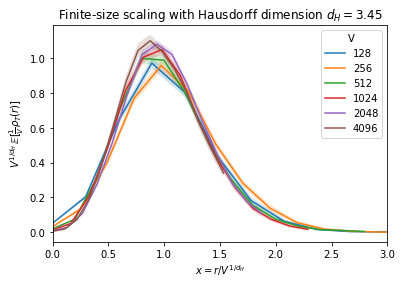

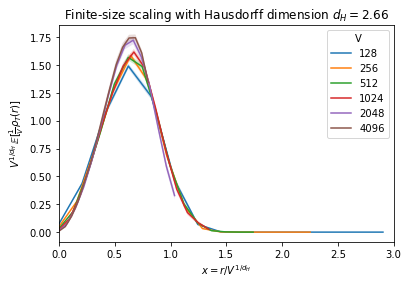

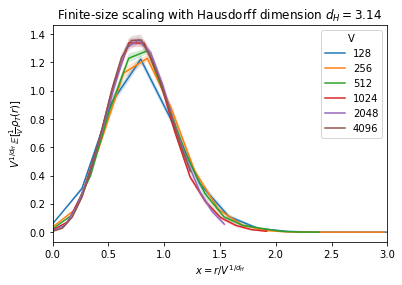

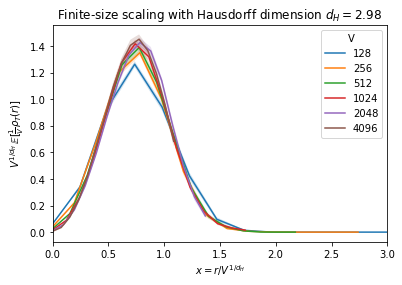

In [22]:
models = ['U','W','S','B']
sizes = [2**k for k in range(7,13)]
num_vertices = (np.array(sizes)+4)/2
equilibration_sweeps = 500
measurement_sweeps = 2
measurements = 200

max_distance = 15

for model in models:
    d_H = d_H_list[model]
    
    # Code mostly copied from lecture 8.
    mean_profiles = []
    for size in sizes:
        #adj = generate_random_triangulation(size, model)
        #perform_sweeps(adj,equilibration_sweeps)
        profiles = []
        for _ in range(measurements):
            #perform_sweeps(adj,measurement_sweeps)
            adj = generate_random_triangulation(size, model)
            profiles.append(vertex_distance_profile(adj,max_distance))
        mean_profiles.append([batch_estimate(data,np.mean,20) for data in np.transpose(profiles)])

    #for profile in mean_profiles:
    #    plt.plot([y[0] for y in profile])
    #for profile in mean_profiles:
    #    plt.fill_between(range(len(profile)),
    #                     [y[0]-y[1] for y in profile],[y[0]+y[1] for y in profile],alpha=0.2)
    #plt.legend(num_vertices, title="V")
    #plt.xlabel("x")
    #plt.ylabel(r"$\mathbb{E}[\rho_T(r)]$")
    #plt.title("Mean distance profile (errors shown as shaded regions)")
    #plt.show()

    for i, profile in enumerate(mean_profiles):
        rvals = np.arange(len(profile))
        plt.plot(rvals/num_vertices[i]**(1/d_H),
                 [y[0]*num_vertices[i]**(1/d_H - 1) for y in profile])
    for i, profile in enumerate(mean_profiles):
        plt.fill_between(np.arange(len(profile))/num_vertices[i]**(1/d_H),
                         [(y[0]-y[1])*num_vertices[i]**(1/d_H - 1) for y in profile],
                         [(y[0]+y[1])*num_vertices[i]**(1/d_H - 1) for y in profile],
                         alpha=0.2)
    plt.legend(sizes, title="V")
    plt.xlabel(r"$x = r/V^{1/d_H}$")
    plt.ylabel(r"$V^{1/d_H}\,\mathbb{E}[\frac{1}{V}\rho_T(r)]$")
    plt.xlim(0,3)
    plt.title(f"Finite-size scaling with Hausdorff dimension $d_H = {d_H:.2f}$")
    plt.show()



**(e) Bonus exercise:** Make more robust estimates of $d_H$ by optimizing the quality of the collapse. You could do this (for each model separately) by taking $\hat{f}(r) = \mathbb{E}[\rho_T(r)] / V_0$, where the right-hand side is the mean distance profile for the largest system size with $V_0 = (2^{12} + 4)/2$ vertices. Then according to our assumption, for another size $V \leq V_0$ we expect $\mathbb{E}[\rho_T(r)] / V \approx k \hat{f}(kr)$, where $k \geq 1$ is a scale factor that should be $k\approx (V_0/V)^{1/d_H}$. Making sure to interpolate the function $\hat{f}(r)$ (using [`scipy.interpolate.interp1d`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html#scipy.interpolate.interp1d)), this scale factor can be determined by fitting the curve $k \hat{f}(kr)$ to the data $\mathbb{E}[\rho_T(r)] / V$. Then $d_H$ can be estimated by fitting $k$ versus $V$. **(20 bonus points, but note that maximum grade is 10)**

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()